In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq  
from sklearn.linear_model import Ridge
from tqdm import tqdm
from utils import *

In [2]:
def generate_data(
    n_total: int,
    p: int,
    N_model: int,
    std: float = 1.0,
    theta: np.ndarray = None,
    random_state: int = None
):
    rng = np.random.RandomState(random_state)

    # 1) Generate theta if not provided
    if theta is None:
        theta = rng.uniform(low=-1.0, high=1.0, size=p) # * 100
        theta = theta / np.linalg.norm(theta)
    
    # 2) Generate total data
    # locs = rng.uniform(low=0, high=1000, size=p)
    # scales = np.ones(p) # * 100
    # X_total = rng.normal(loc=locs, scale=scales, size=(n_total, p))

    X_total = rng.normal(size=(n_total, p))
    noise_eval = std * rng.normal(size=n_total)
    # noise_eval = std * rng.normal(size=n_total) * (1 + 0.01 * np.linalg.norm(X_total, axis=1))

    Y_total = X_total @ theta + noise_eval

    # 3) Generate predictions
    #X_model = rng.normal(loc=locs, scale=scales, size=(N_model, p))
    X_model = rng.normal(size=(N_model, p))
    noise_model = std * rng.normal(size=N_model)
    # noise_model = std * rng.normal(size=N_model)  * (1 + 0.01 * np.linalg.norm(X_model, axis=1))
    Y_model = X_model @ theta + noise_model

    model = OLS(Y_model, X_model).fit()
    Y_hat = model.predict(X_total)
    # f_model = Ridge(alpha=1.0).fit(X_model, Y_model)
    # Y_hat = f_model.predict(X_total) 

    return X_total, Y_total, Y_hat, theta, X_total @ theta

In [3]:
# Set global parameters
ratios = [0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 5.0]
std_list =  [0.1, 1.0, 5.0, 10.0]
ns = [10, 20, 50, 100] 
ps = [20, 50, 100, 200]
rng = np.random.RandomState()

num_trials = 10
alpha = 0.05
# coordinate = 1
N_model = 2000
n_total = 5000
p_total = 1000

# X_total, Y_total, Yhat_total, true_theta, Y_raw = generate_data(n_total, p_total, N_model, std=1.0, random_state=42)

In [37]:
from statsmodels.stats.weightstats import _zconfint_generic
from scipy.linalg import pinv

def classical_ols_ci_pse(X, Y, alpha=0.1, alternative="two-sided"):
    """
    Compute confidence interval for OLS coefficients using HC0 robust SE
    and generalized inverse, suitable when X may be rank-deficient.

    Returns:
        (lower, upper): arrays of shape (p,) for each coefficient.
    """
    n, p = X.shape
    pinv_X = pinv(X)
    theta_hat = pinv_X @ Y

    residuals = Y - X @ theta_hat
    e2 = residuals ** 2
    middle = X.T @ np.diag(e2) @ X
    cov = pinv(X.T @ X) @ middle @ pinv(X.T @ X)
    se = np.sqrt(np.diag(cov))

    return _zconfint_generic(theta_hat, se, alpha, alternative)


In [24]:
_X_total, Y_total, Yhat_total, theta, _ = generate_data(20, 200, N_model, std=1.0)
np.corrcoef(Y_total, Yhat_total)[0, 1]

0.6938738688724799

In [25]:
# Run experiments
results = []
for p in ps:
    _X_total, Y_total, Yhat_total, theta, _ = generate_data(n_total, p, N_model, std=1.0)
    # p_select = np.random.choice(X_total.shape[1], p, replace=False)
    # _X_total = X_total[:, p_select]
    # theta = true_theta[p_select]
    for ratio in ratios:
        print(f"  Ratio: {ratio}, p: {p}")
        n = int(p * ratio)
        for trial in range(num_trials):
            idx = np.random.permutation(n_total)
            X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
            Y_labeled, Y_unlabeled = Y_total[idx[:n]], Y_total[idx[n:]]
            Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

            try:
                # PPI
                ppi_ci = ppi_ols_ci(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, alpha=alpha, lam = 1.0)

                if ppi_ci is None or np.any(np.isnan(ppi_ci)) or np.any(np.isinf(ppi_ci)):
                    raise ValueError(f"PPI CI invalid at p={p}, ratio={ratio}, trial={trial}")

                ppi_mid = 0.5 * (ppi_ci[0] + ppi_ci[1])
                ppi_cover = ((ppi_ci[0] <= theta) & (theta <= ppi_ci[1])).mean()
                ppi_error = (ppi_mid-theta)**2    #l2 norm
                ppi_width = ppi_ci[1] - ppi_ci[0]

                results.append({ 
                    "method": "PPI", "p": p, "n": n, "ratio": ratio, "trial": trial, "std": 1.0,
                    "lower": ppi_ci[0].mean(), "upper": ppi_ci[1].mean(), 
                    "width": ppi_width.mean(), "width_max": ppi_width.max(), "width_min": ppi_width.min(),
                    "coverage": ppi_cover, "theta": theta.mean(),
                    "error": ppi_error.mean(), "error_max": ppi_error.max(), "error_min": ppi_error.min()
                })

            except Exception as e:
                print(f"[PPI ERROR] p={p}, ratio={ratio}, trial={trial}: {e}")
                break

            try:

                # Classical
                classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)

                if classical_ci is None or np.any(np.isnan(classical_ci)) or np.any(np.isinf(classical_ci)):
                    raise ValueError(f"Classical CI invalid at p={p}, ratio={ratio}, trial={trial}")

                classical_mid = 0.5 * (classical_ci[0] + classical_ci[1])
                classical_cover = ((classical_ci[0] <= theta) & (theta <= classical_ci[1])).mean()
                classical_error = (classical_mid - theta) ** 2
                classical_width = classical_ci[1] - classical_ci[0]
                results.append({
                    "method": "Classical", "p": p, "n": n, "ratio": ratio, "trial": trial, "std": 1.0,
                    "lower": classical_ci[0].mean(), "upper": classical_ci[1].mean(), 
                    "width": classical_width.mean(), "width_max": classical_width.max(), "width_min": classical_width.min(),
                    "coverage": classical_cover, 
                    "error": classical_error.mean(), "error_max": classical_error.max(), "error_min": classical_error.min()
                })

            # average max min
            except Exception as e:
                print(f"[Classical ERROR] p={p}, ratio={ratio}, trial={trial}: {e}")
                break
        
        # Imputed CI
        imputed_ci = classical_ols_ci(_X_total, Yhat_total, alpha=alpha)
        results.append({
            "method": "Imputation",
            "n": n,
            "p": p,
            "ratio": ratio,
            "trial": 0,
            "std": 1.0,
            "lower": imputed_ci[0].mean(),
            "upper": imputed_ci[1].mean(),
            "width": (imputed_ci[1] - imputed_ci[0]).mean(),
            "coverage": np.nan,
            "error": np.nan,
        })

# Compile and compute widths
df4 = pd.DataFrame(results)
df4.to_csv("experiment_results4.csv", index=False)

  Ratio: 0.1, p: 20
  Ratio: 0.2, p: 20
  Ratio: 0.5, p: 20
  Ratio: 0.8, p: 20
  Ratio: 1.0, p: 20
  Ratio: 2.0, p: 20
  Ratio: 5.0, p: 20
  Ratio: 0.1, p: 50
  Ratio: 0.2, p: 50
  Ratio: 0.5, p: 50
  Ratio: 0.8, p: 50
  Ratio: 1.0, p: 50
  Ratio: 2.0, p: 50
  Ratio: 5.0, p: 50
  Ratio: 0.1, p: 100
  Ratio: 0.2, p: 100
  Ratio: 0.5, p: 100
  Ratio: 0.8, p: 100
  Ratio: 1.0, p: 100
  Ratio: 2.0, p: 100
  Ratio: 5.0, p: 100
  Ratio: 0.1, p: 200
  Ratio: 0.2, p: 200
  Ratio: 0.5, p: 200
  Ratio: 0.8, p: 200
  Ratio: 1.0, p: 200
  Ratio: 2.0, p: 200
  Ratio: 5.0, p: 200


In [ ]:
# Run experiments
results = []
for std in tqdm(std_list, desc="std loop"):
    noise = std * rng.normal(size=n_total) # * (1 + 0.01 * np.linalg.norm(X_total, axis=1))
    Y_total = Y_raw + noise
    for n in ns:
        for ratio in ratios:
            print(f"  Ratio: {ratio}, n: {n}")
            p = int(n / ratio)
            _X_total = X_total[:, np.random.choice(X_total.shape[1], p, replace=False)]
            for trial in range(num_trials):
                idx = np.random.permutation(n_total)
                X_labeled, X_unlabeled = _X_total[idx[:n]], _X_total[idx[n:]]
                Y_labeled, Y_unlabeled = Y_total[idx[:n]], Y_total[idx[n:]]
                Yhat_labeled, Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

                # PPI
                ppi_ci = ppi_ols_ci(X_labeled, Y_labeled, Yhat_labeled, X_unlabeled, Yhat_unlabeled, alpha=alpha)

                ppi_mid = 0.5 * (ppi_ci[0][coordinate] + ppi_ci[1][coordinate])
                ppi_cover = int(ppi_ci[0][coordinate] <= theta[coordinate] <= ppi_ci[1][coordinate])
                ppi_error = abs(ppi_mid - theta[coordinate])   #l2 norm

                results.append({ 
                    "method": "PPI", "p": p, "n": n, "ratio": ratio, "trial": trial, "std": std,
                    "lower": ppi_ci[0][coordinate], "upper": ppi_ci[1][coordinate],
                    "coverage": ppi_cover, "error": ppi_error
                })

                # Classical
                if n >= p:
                    classical_ci = classical_ols_ci(X_labeled, Y_labeled, alpha=alpha)
                    classical_mid = 0.5 * (classical_ci[0][coordinate] + classical_ci[1][coordinate])
                    classical_cover = int(classical_ci[0][coordinate] <= theta[coordinate] <= classical_ci[1][coordinate])
                    classical_error = abs(classical_mid - theta[coordinate])
                    results.append({
                        "method": "Classical", "p": p, "n": n, "ratio": ratio, "trial": trial, "std": std,
                        "lower": classical_ci[0][coordinate], "upper": classical_ci[1][coordinate],
                        "coverage": classical_cover, "error": classical_error
                    })

                    # average max min

# Compile and compute widths
df3 = pd.DataFrame(results)
df3["width"] = df3["upper"] - df3["lower"]
df3.to_csv("experiment_results3.csv", index=False)

std loop:   0%|          | 0/4 [00:00<?, ?it/s]

  Ratio: 0.1, n: 10
  Ratio: 0.2, n: 10
  Ratio: 0.5, n: 10
  Ratio: 0.8, n: 10
  Ratio: 1.0, n: 10
  Ratio: 2.0, n: 10
  Ratio: 5.0, n: 10
  Ratio: 0.1, n: 20
  Ratio: 0.2, n: 20
  Ratio: 0.5, n: 20
  Ratio: 0.8, n: 20
  Ratio: 1.0, n: 20
  Ratio: 2.0, n: 20
  Ratio: 5.0, n: 20
  Ratio: 0.1, n: 50
  Ratio: 0.2, n: 50
  Ratio: 0.5, n: 50
  Ratio: 0.8, n: 50
  Ratio: 1.0, n: 50
  Ratio: 2.0, n: 50
  Ratio: 5.0, n: 50
  Ratio: 0.1, n: 100
  Ratio: 0.2, n: 100
  Ratio: 0.5, n: 100
  Ratio: 0.8, n: 100
  Ratio: 1.0, n: 100
  Ratio: 2.0, n: 100
  Ratio: 5.0, n: 100


std loop:  25%|██▌       | 1/4 [4:42:53<14:08:40, 16973.57s/it]

  Ratio: 0.1, n: 10
  Ratio: 0.2, n: 10
  Ratio: 0.5, n: 10
  Ratio: 0.8, n: 10
  Ratio: 1.0, n: 10
  Ratio: 2.0, n: 10
  Ratio: 5.0, n: 10
  Ratio: 0.1, n: 20
  Ratio: 0.2, n: 20
  Ratio: 0.5, n: 20
  Ratio: 0.8, n: 20
  Ratio: 1.0, n: 20
  Ratio: 2.0, n: 20
  Ratio: 5.0, n: 20
  Ratio: 0.1, n: 50
  Ratio: 0.2, n: 50
  Ratio: 0.5, n: 50
  Ratio: 0.8, n: 50
  Ratio: 1.0, n: 50
  Ratio: 2.0, n: 50
  Ratio: 5.0, n: 50
  Ratio: 0.1, n: 100
  Ratio: 0.2, n: 100
  Ratio: 0.5, n: 100
  Ratio: 0.8, n: 100
  Ratio: 1.0, n: 100
  Ratio: 2.0, n: 100
  Ratio: 5.0, n: 100


std loop:  50%|█████     | 2/4 [6:12:48<5:38:45, 10162.66s/it] 

  Ratio: 0.1, n: 10
  Ratio: 0.2, n: 10
  Ratio: 0.5, n: 10
  Ratio: 0.8, n: 10
  Ratio: 1.0, n: 10
  Ratio: 2.0, n: 10
  Ratio: 5.0, n: 10
  Ratio: 0.1, n: 20
  Ratio: 0.2, n: 20
  Ratio: 0.5, n: 20
  Ratio: 0.8, n: 20
  Ratio: 1.0, n: 20
  Ratio: 2.0, n: 20
  Ratio: 5.0, n: 20
  Ratio: 0.1, n: 50
  Ratio: 0.2, n: 50
  Ratio: 0.5, n: 50
  Ratio: 0.8, n: 50
  Ratio: 1.0, n: 50
  Ratio: 2.0, n: 50
  Ratio: 5.0, n: 50
  Ratio: 0.1, n: 100
  Ratio: 0.2, n: 100
  Ratio: 0.5, n: 100
  Ratio: 0.8, n: 100
  Ratio: 1.0, n: 100
  Ratio: 2.0, n: 100
  Ratio: 5.0, n: 100


std loop:  75%|███████▌  | 3/4 [7:46:59<2:15:02, 8102.53s/it] 

  Ratio: 0.1, n: 10
  Ratio: 0.2, n: 10
  Ratio: 0.5, n: 10
  Ratio: 0.8, n: 10
  Ratio: 1.0, n: 10
  Ratio: 2.0, n: 10
  Ratio: 5.0, n: 10
  Ratio: 0.1, n: 20
  Ratio: 0.2, n: 20
  Ratio: 0.5, n: 20
  Ratio: 0.8, n: 20
  Ratio: 1.0, n: 20
  Ratio: 2.0, n: 20
  Ratio: 5.0, n: 20
  Ratio: 0.1, n: 50
  Ratio: 0.2, n: 50
  Ratio: 0.5, n: 50
  Ratio: 0.8, n: 50
  Ratio: 1.0, n: 50
  Ratio: 2.0, n: 50
  Ratio: 5.0, n: 50
  Ratio: 0.1, n: 100
  Ratio: 0.2, n: 100
  Ratio: 0.5, n: 100
  Ratio: 0.8, n: 100
  Ratio: 1.0, n: 100
  Ratio: 2.0, n: 100
  Ratio: 5.0, n: 100


std loop: 100%|██████████| 4/4 [9:20:43<00:00, 8410.81s/it]  


In [5]:
df3 = pd.read_csv("experiment_results3.csv")

In [6]:
# Imputed CI
imputed_ci = classical_ols_ci(X_total, Yhat_total, alpha=alpha)
df_impute = pd.DataFrame([{
    "method": "Imputation",
    "n": np.nan,
    "p": np.nan,
    "ratio": np.nan,
    "trial": 0,
    "std": np.nan,
    "lower": imputed_ci[0][coordinate],
    "upper": imputed_ci[1][coordinate],
    "width": imputed_ci[1][coordinate] - imputed_ci[0][coordinate],
    "coverage": np.nan,
    "error": np.nan,
}])
df3 = pd.concat([df3, df_impute], ignore_index=True)


# Plotting

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df4[df4["method"] != "Imputation"]

# df = df[df["ratio"] != 1]

df_avg = df.groupby(["method", "p", "ratio"]).agg({
    "error": "mean"
}).reset_index()

sns.set(style="whitegrid", font_scale=1.2)

for p_val in sorted(df_avg["p"].unique()):
    subset = df_avg[df_avg["p"] == p_val]
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=subset, x="ratio", y="error", hue="method", marker="o")
    plt.title(f"Estimation Error vs Ratio (p = {p_val})")
    plt.xlabel("n / p (Ratio)")
    plt.ylabel("Mean Squared Error")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


NameError: name 'df4' is not defined

## Old Plots

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_combined_heatmap_ratio_std(df):
    summary = df.groupby(["std", "ratio"])["width"].mean().reset_index()
    pivot = summary.pivot(index="std", columns="ratio", values="width")
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Avg. PPI CI Widths by n/p Ratio and Noise Std (aggregated over p)")
    plt.xlabel("n / p ratio")
    plt.ylabel("Noise Std")
    plt.tight_layout()
    plt.show()

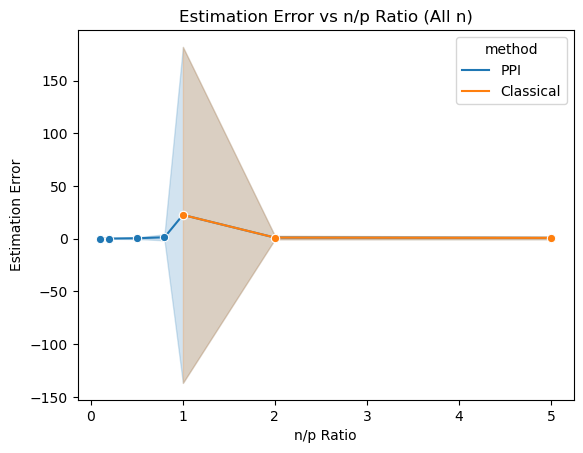

In [62]:
sns.lineplot(data=df3, x="ratio", y="error", hue="method", ci="sd", marker="o")
plt.title("Estimation Error vs n/p Ratio (All n)")
plt.xlabel("n/p Ratio")
plt.ylabel("Estimation Error")
plt.show()

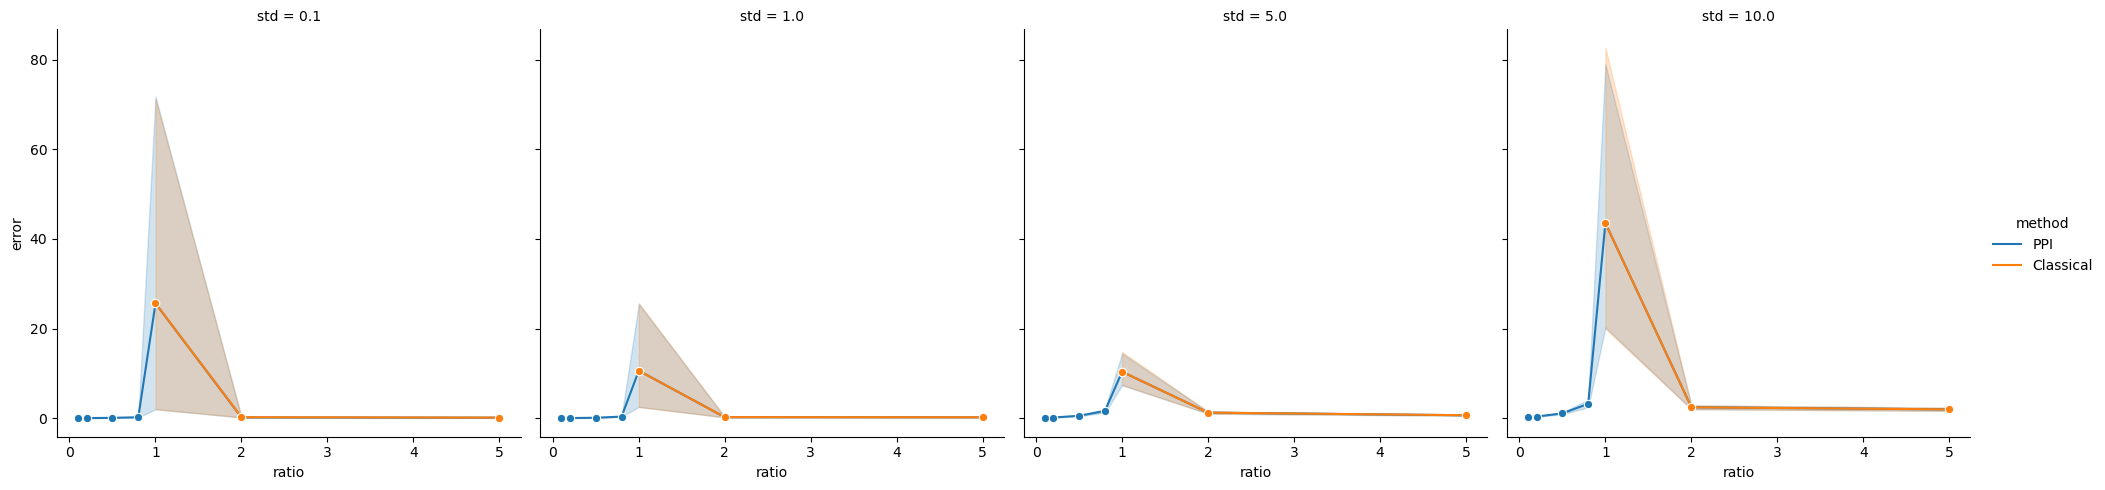

In [64]:
sns.relplot(
    data=df3, x="ratio", y="error", hue="method",
    col="std", kind="line", marker="o",
    facet_kws={"sharey": True}
)

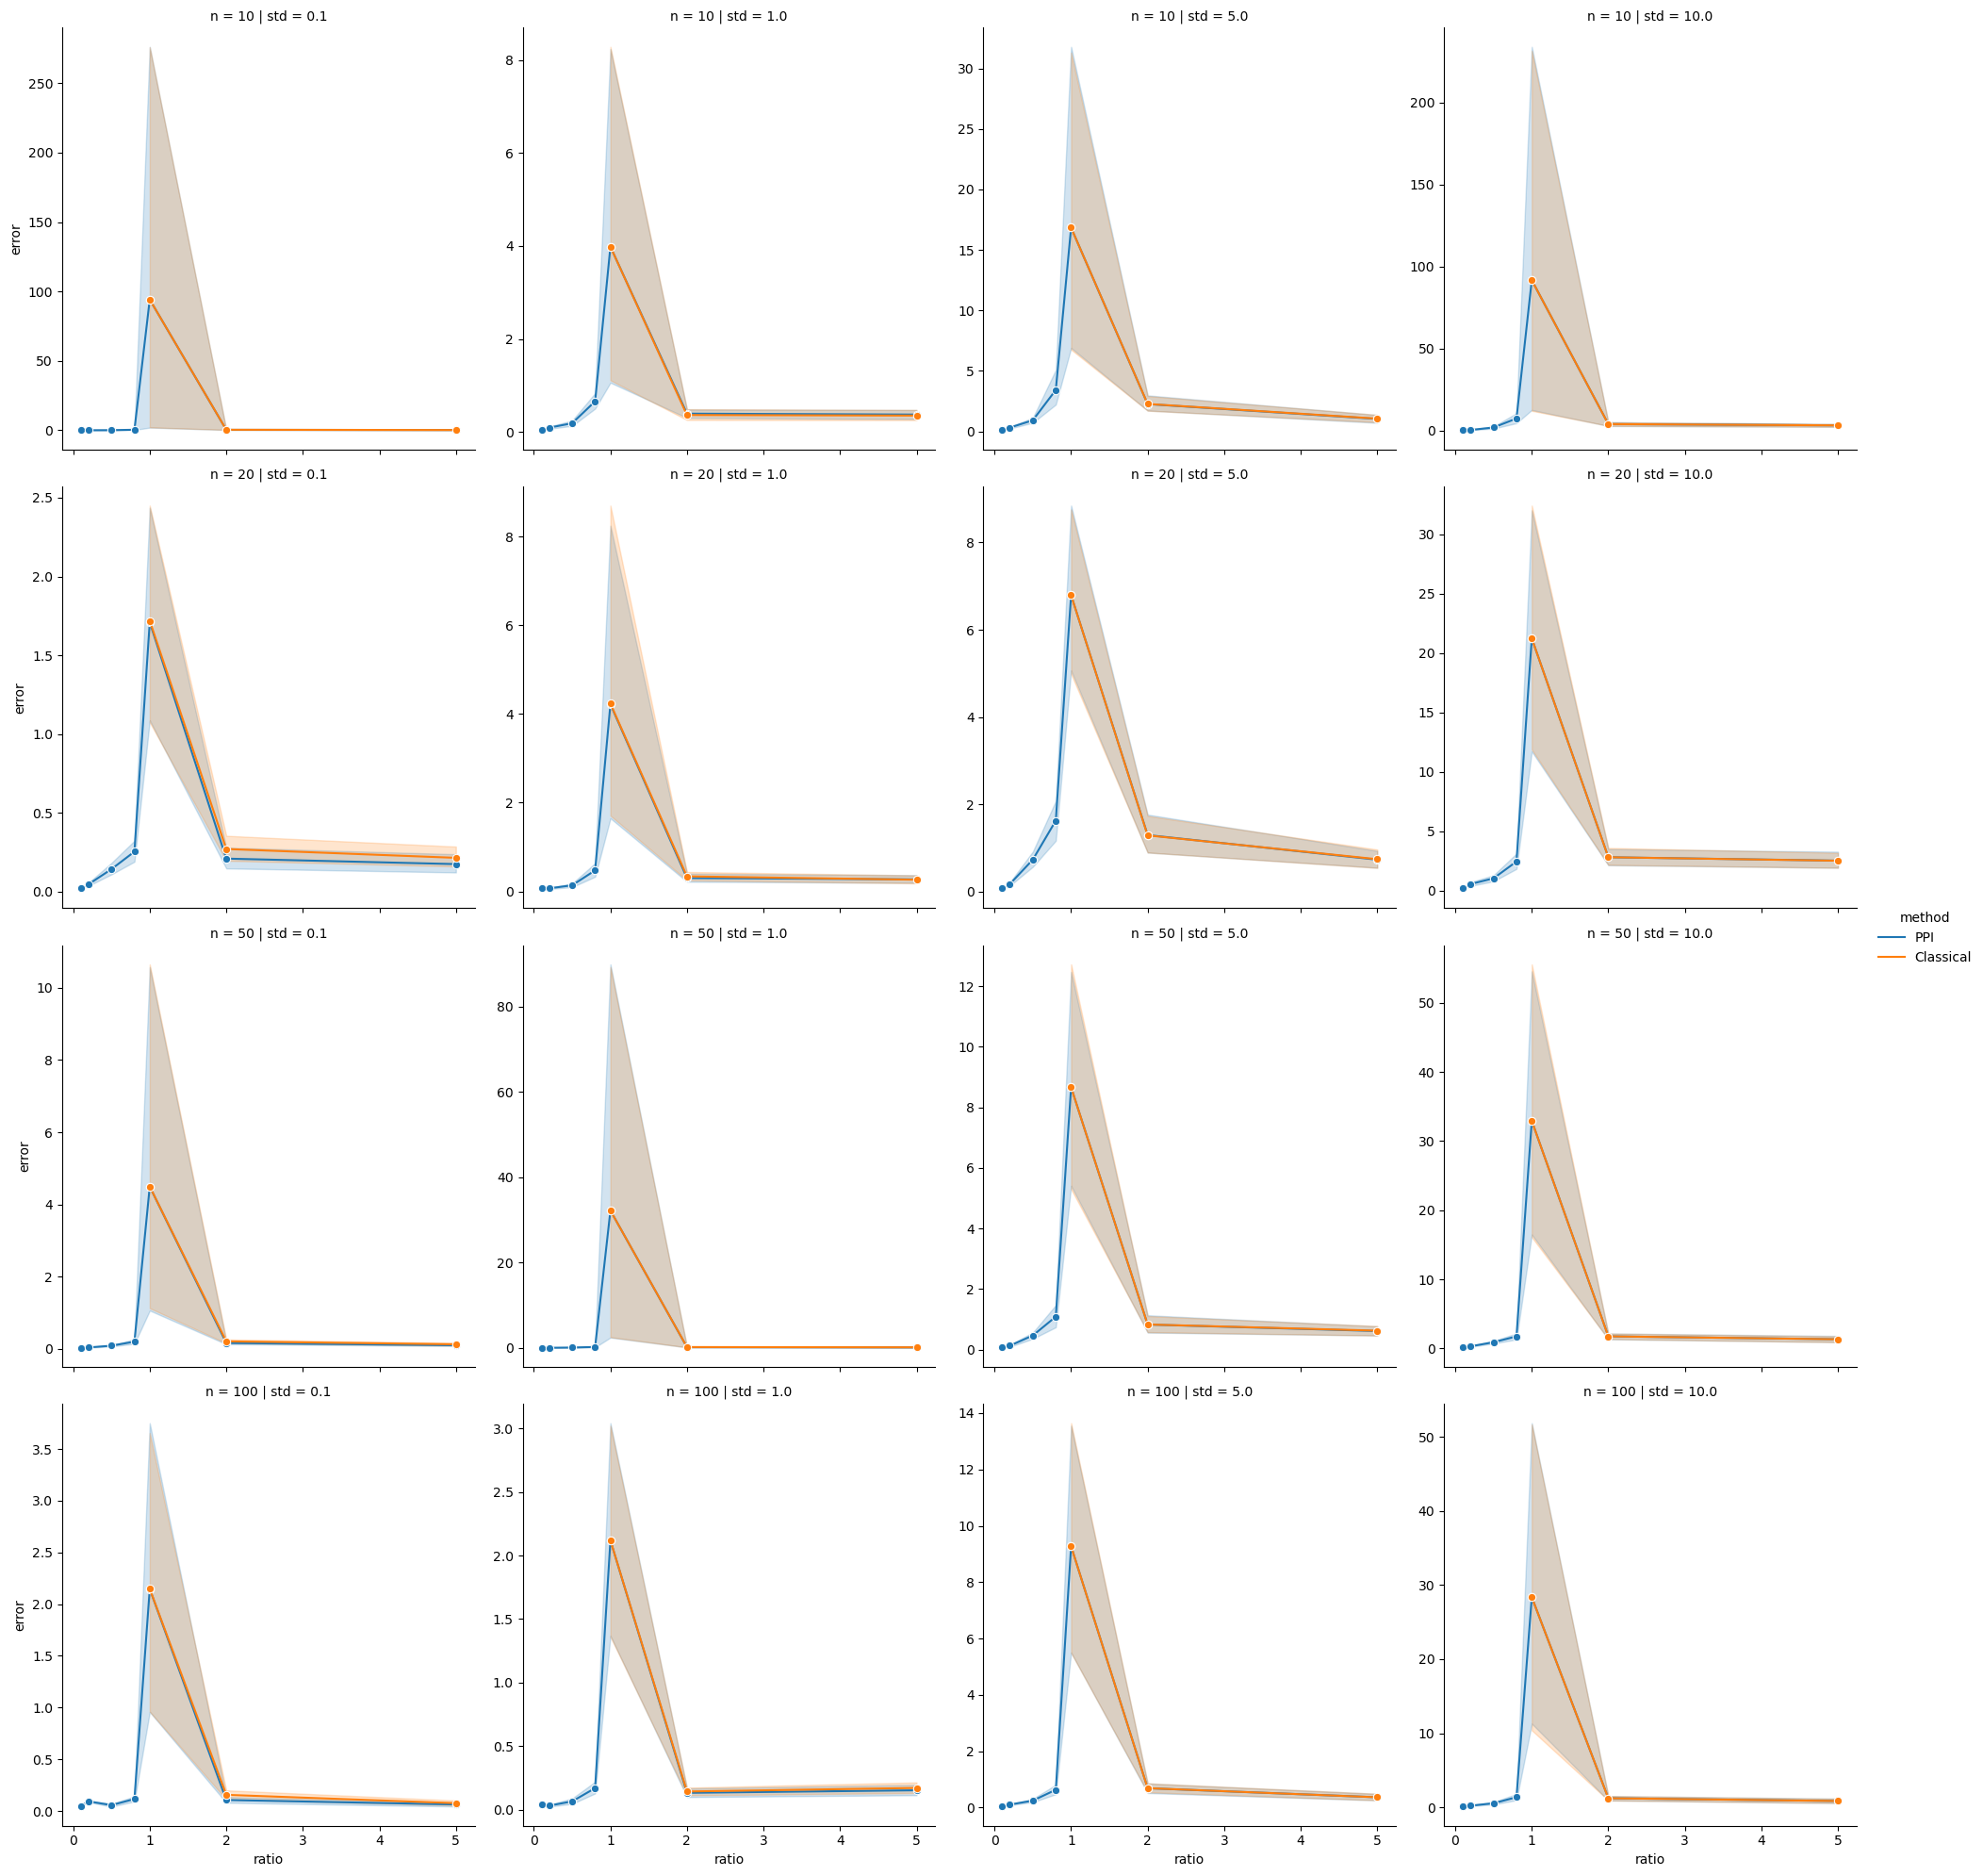

In [65]:
sns.relplot(
    data=df3, x="ratio", y="error", hue="method",
    col="std", row="n", kind="line", marker="o",
    facet_kws={"sharey": False}
)


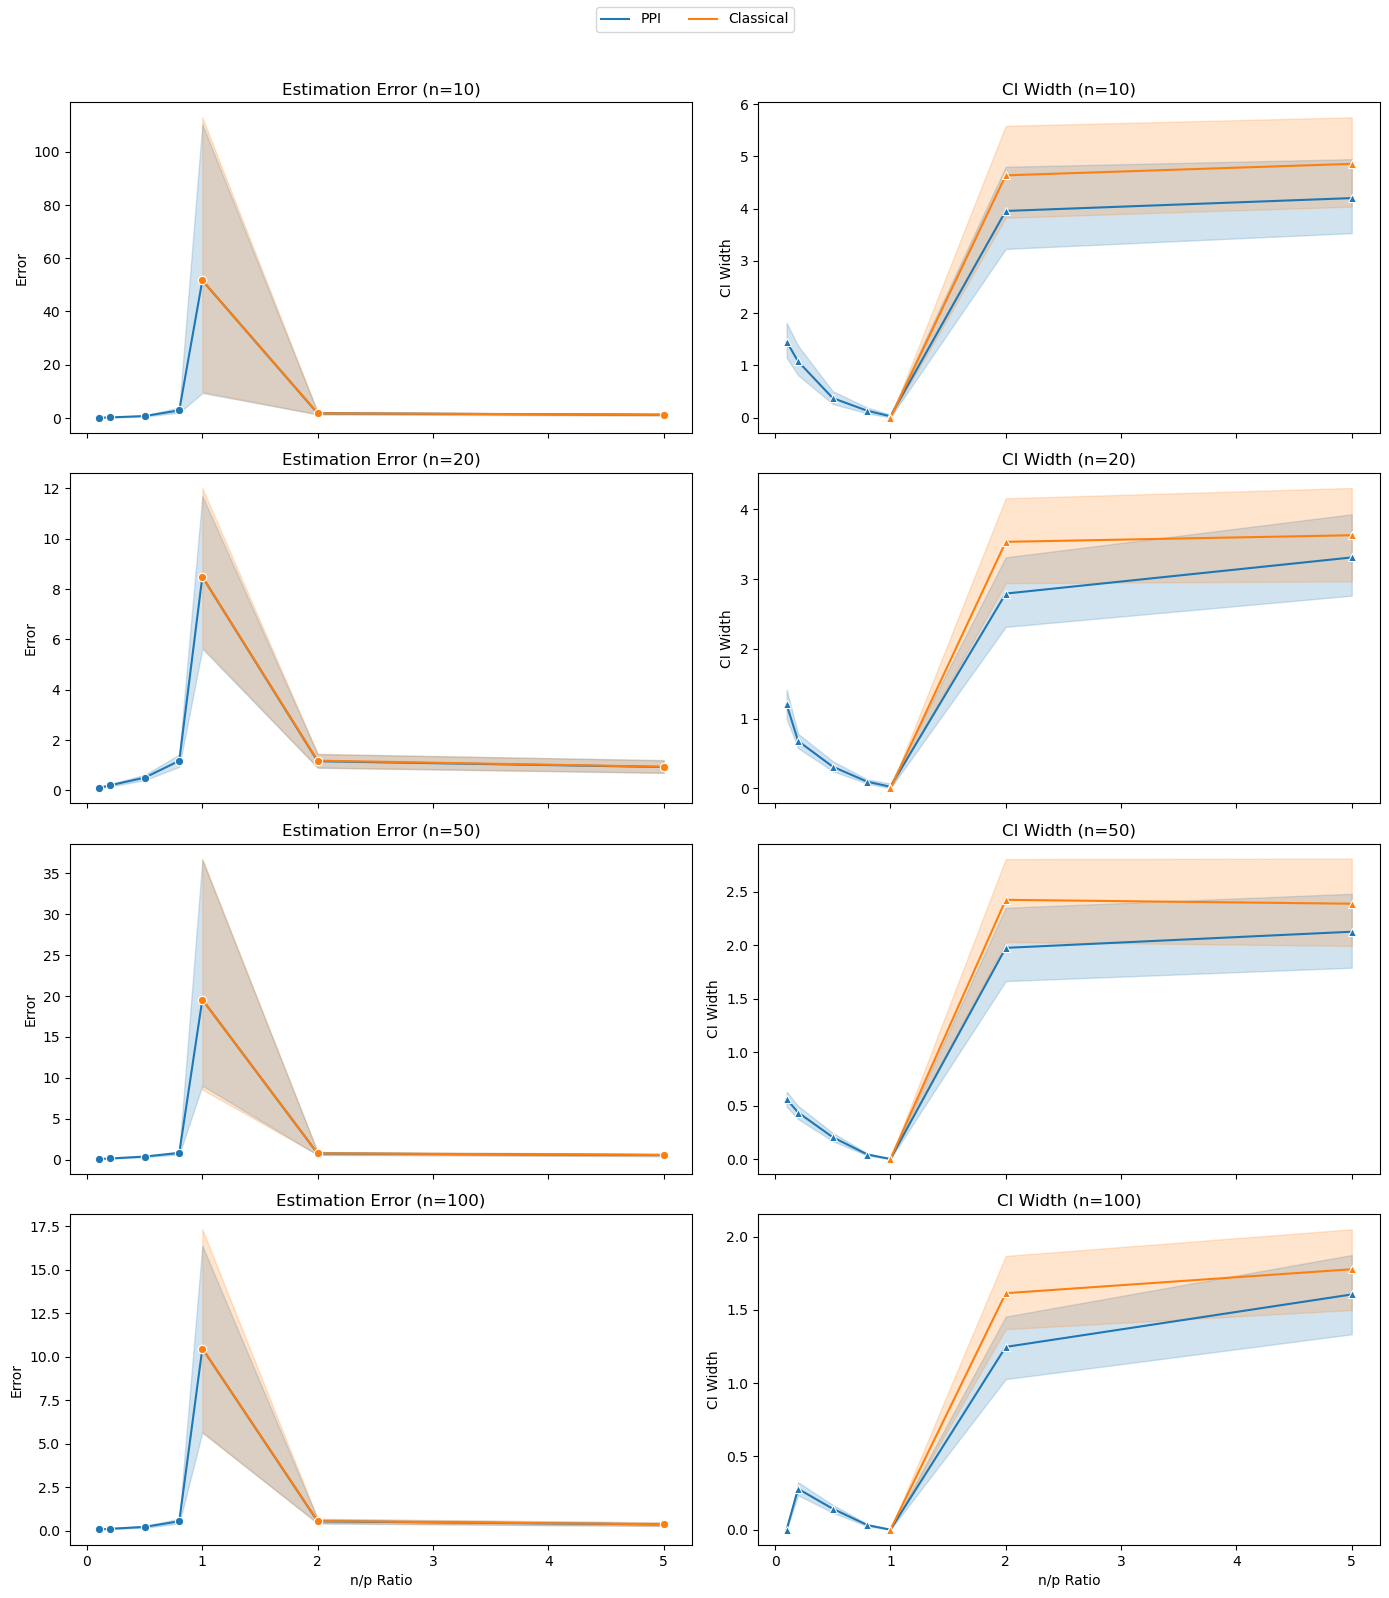

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df3 = pd.read_csv("experiment_results3.csv")  # 确保你有这个文件

def plot_error_and_ci_by_n(df):
    """
    Plot estimation error and confidence interval (CI) width by n value.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns ['n', 'ratio', 'error', 'width', 'method']
    """
    n_values = sorted(df["n"].unique())
    num_n = len(n_values)
    fig, axes = plt.subplots(nrows=num_n, ncols=2, figsize=(14, 4 * num_n), sharex=True)

    for i, n_val in enumerate(n_values):
        subset = df[df["n"] == n_val]

        # Estimation Error
        sns.lineplot(
            data=subset, x="ratio", y="error", hue="method", marker="o", ax=axes[i][0]
        )
        axes[i][0].set_title(f"Estimation Error (n={n_val})")
        axes[i][0].set_ylabel("Error")
        axes[i][0].set_xlabel("n/p Ratio")

        # CI Width
        sns.lineplot(
            data=subset, x="ratio", y="width", hue="method", marker="^", ax=axes[i][1]
        )
        axes[i][1].set_title(f"CI Width (n={n_val})")
        axes[i][1].set_ylabel("CI Width")
        axes[i][1].set_xlabel("n/p Ratio")

    # Unified legend
    handles, labels = axes[0][0].get_legend_handles_labels()
    for axrow in axes:
        for ax in (axrow if isinstance(axrow, (list, tuple, np.ndarray)) else [axrow]):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_error_and_ci_by_n(df3)

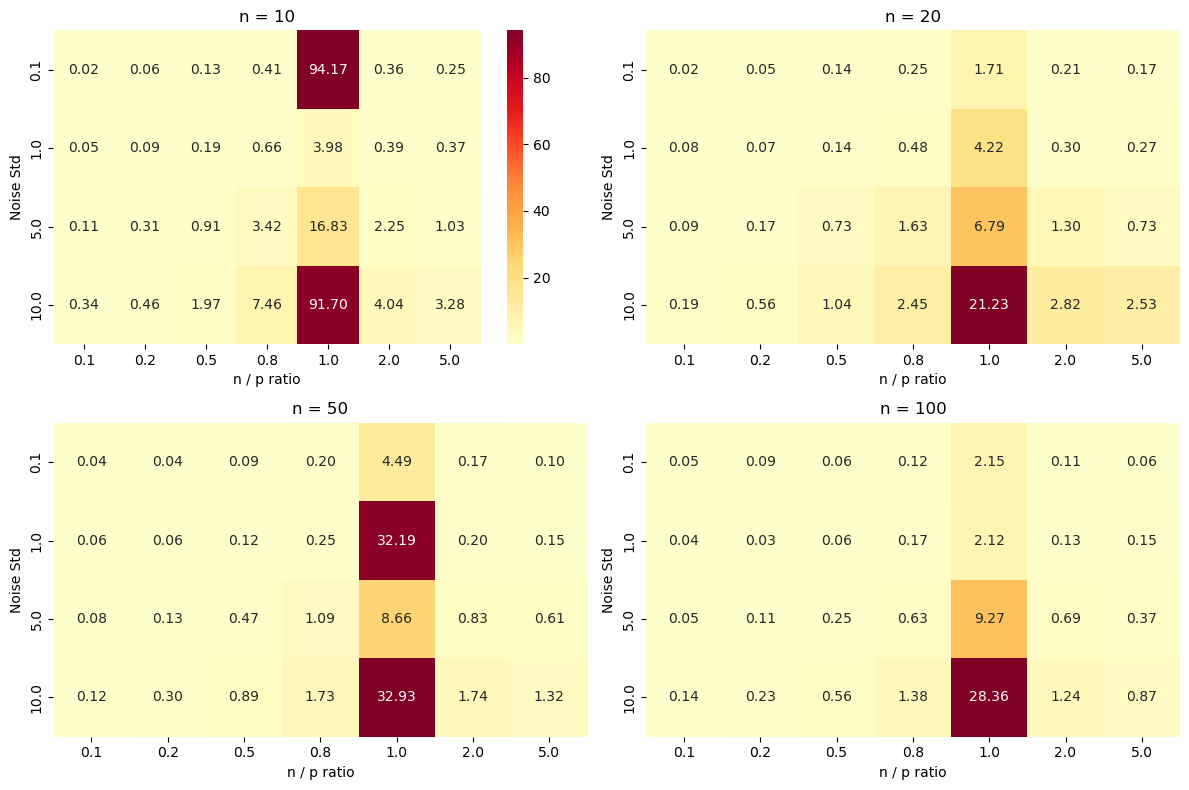

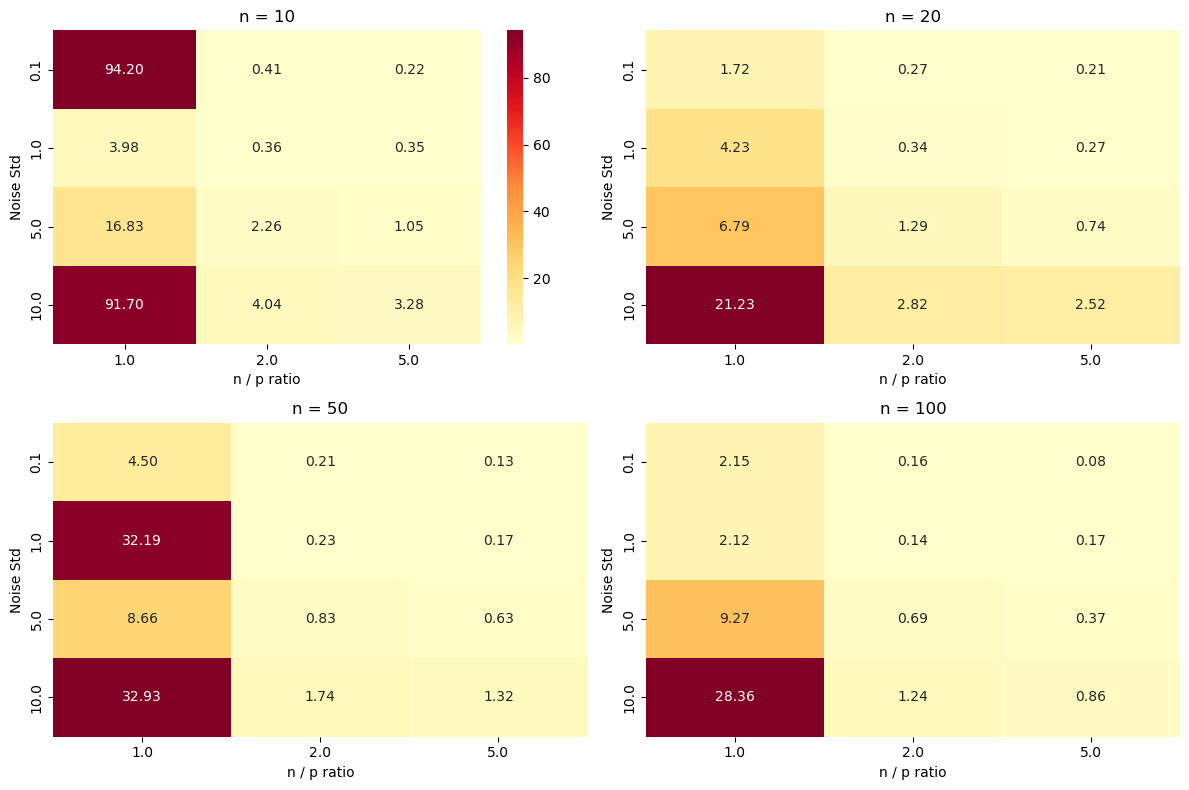

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiple_heatmaps_by_p(df):
    n_values = sorted(df["n"].unique())
    num_cols = 2
    num_rows = (len(n_values) + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

    for i, n in enumerate(n_values):
        ax = axes.flat[i]
        df_n = df[df["n"] == n]
        summary = df_n.groupby(["std", "ratio"])["error"].mean().reset_index()
        pivot = summary.pivot(index="std", columns="ratio", values="error")
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax, cbar=i == 0)
        ax.set_title(f"n = {n}")
        ax.set_xlabel("n / p ratio")
        ax.set_ylabel("Noise Std")

    plt.tight_layout()
    plt.show()

plot_multiple_heatmaps_by_p(df3[df3["method"] == "PPI"])
plot_multiple_heatmaps_by_p(df3[df3["method"] == "Classical"])
plt.show()

In [ ]:
df3_sub = df3[df3["ratio"] >= 1.0]

for std_plot in std_list:
    for p_plot in sorted(df3_sub["p"].unique()):
        df_sub = df3_sub[(df3_sub["p"] == p_plot) & (df3_sub["std"] == std_plot)].copy()
        if df_sub.empty:
            continue

        imp_row = df3[(df3["method"] == "Imputation")]
        df_plot = pd.concat([df_sub, imp_row], ignore_index=True)

        make_plots(
            df_plot,
            f"./plots/ppi_comparison_p{p_plot}_std{std_plot}.pdf",
            intervals_xlabel=f"OLS coeff (p={p_plot})",
            true_theta=theta[coordinate]
        )